In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install gensim==3.8.3
import pickle
import gensim.downloader
from gensim.models import Word2Vec
import nltk.data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import logging
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import decomposition
print(gensim.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
3.8.3


In [ ]:
url = "https://raw.githubusercontent.com/soujanyaporia/MUStARD/master/data/sarcasm_data.json"
df = pd.read_json(url,orient='index')
df.head(5)

,utterance,speaker,context,context_speakers,show,sarcasm
160,It's just a privilege to watch your mind at work.,SHELDON,[I never would have identified the fingerprint...,"[LEONARD, SHELDON]",BBT,True
170,I don't think I'll be able to stop thinking ab...,PENNY,[This is one of my favorite places to kick bac...,"[HOWARD, PENNY, HOWARD, HOWARD, HOWARD, PENNY,...",BBT,True
180,"Since it's not bee season, you can have my epi...",SHELDON,"[Here we go. Pad thai, no peanuts., But does i...","[LEONARD, HOWARD, LEONARD]",BBT,False
190,"Lois Lane is falling, accelerating at an initi...",SHELDON,[A marathon? How many Superman movies are ther...,"[PENNY, SHELDON, PENNY, SHELDON, SHELDON, PENN...",BBT,False
1105,I'm just inferring this is a couch because the...,SHELDON,"[Great Caesar's ghost, look at this place., So...","[SHELDON, LEONARD, SHELDON, SHELDON, SHELDON, ...",BBT,True


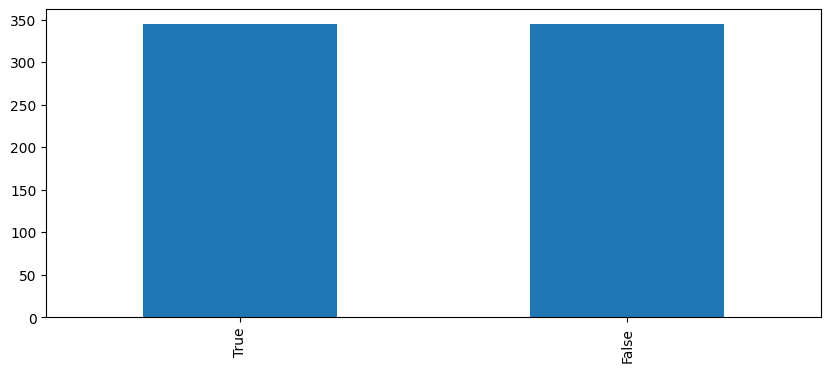

In [ ]:
# plt.figure(figsize=(10,4))
# df["sarcasm"].value_counts().plot(kind='bar');

In [ ]:
# w10 lab
%%time

wv1 = gensim.downloader.load('word2vec-google-news-300')
wv1.init_sims(replace=True)
print('Model loaded')

Model loaded
CPU times: user 1min 2s, sys: 8.98 s, total: 1min 11s
Wall time: 1min 23s


In [ ]:
file = open('drive/MyDrive/wv_gnews300_383', 'wb')

# dump information to that file
pickle.dump(wv1, file)

# close the file
file.close()

In [ ]:
# open a file, where you stored the pickled data
file = open('drive/MyDrive/wv_gnews300_383', 'rb')

# dump information to that file
wv = pickle.load(file)

# close the file
file.close()

In [ ]:
# w10 lab
nltk.download('punkt')

def w2v_tokenize_text(text):
    # create tokens, a list of words, for each post. This function will do some cleaning based on English language
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
# w10 lab
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['utterance']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['utterance']), axis=1).values

TypeError: ignored

In [21]:
test_tokenized_context = test.apply(lambda r: w2v_tokenize_text(" ".join(r['context'])), axis=1).values
train_tokenized_context = train.apply(lambda r: w2v_tokenize_text(" ".join(r['context'])), axis=1).values

In [ ]:
#w10 lab
def word_averaging(wv, words):
    # averages a set of words 'words' given their wordvectors 'wv'
    
    all_words, mean = set(), []
    
    # for each word in the list of words
    for word in words:
        # if the words are alread vectors, then just append them
        if isinstance(word, np.ndarray):
            mean.append(word)
        # if not: first get the vector embedding for the words
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    
    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [24]:
# w10 lab
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

X_train_word_average_context = word_averaging_list(wv,train_tokenized_context)
X_test_word_average_context = word_averaging_list(wv,test_tokenized_context)

<ipython-input-9-c644c9e63e6f>:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


In [ ]:
file = open('drive/MyDrive/wv_Xtrain', 'wb')

# dump information to that file
pickle.dump(X_train_word_average, file)

# close the file
file.close()

file = open('drive/MyDrive/wv_Xtext', 'wb')

# dump information to that file
pickle.dump(X_test_word_average, file)

# close the file
file.close()

In [23]:
file = open('drive/MyDrive/wv_Xtrain_context', 'wb')

# dump information to that file
pickle.dump(X_train_word_average_context, file)

# close the file
file.close()

file = open('drive/MyDrive/wv_Xtext_context', 'wb')

# dump information to that file
pickle.dump(X_test_word_average_context, file)

# close the file
file.close()

In [ ]:
pca = decomposition.PCA(n_components=1)
pca.fit(X_train_word_average)
utterance_train = pca.transform(X_train_word_average)

pca = decomposition.PCA(n_components=1)
pca.fit(X_test_word_average)
utterance_test = pca.transform(X_test_word_average)

In [27]:
X_train = np.concatenate([X_train_word_average, X_train_word_average_context], axis=1)
X_test = np.concatenate([X_test_word_average, X_test_word_average_context], axis=1)

In [29]:
clf = SVC()
svm = clf.fit(X_train, train['sarcasm'])
y_pred = svm.predict(X_test)

print(classification_report(test['sarcasm'], y_pred))

              precision    recall  f1-score   support

       False       0.57      0.70      0.63        94
        True       0.70      0.57      0.62       113

    accuracy                           0.63       207
   macro avg       0.63      0.63      0.63       207
weighted avg       0.64      0.63      0.63       207



In [4]:
!pip install transformers 

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
url = "https://raw.githubusercontent.com/soujanyaporia/MUStARD/master/data/sarcasm_data.json"
df = pd.read_json(url,orient='index')
df_train, df_test = train_test_split(df, test_size=0.3, random_state = 42)

In [46]:
# https://towardsdatascience.com/feature-extraction-with-bert-for-text-classification-533dde44dc2f
tokenized_train = tokenizer(df_train["utterance"].values.tolist(), padding = True, truncation = True, return_tensors="pt")
tokenized_val = tokenizer(df_test["utterance"].values.tolist() , padding = True, truncation = True,  return_tensors="pt")

print(tokenized_train.keys())

#move on device (GPU)
tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

with torch.no_grad():
  hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
  hidden_val = model(**tokenized_val)

#get only the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_val = hidden_val.last_hidden_state[:,0,:]

file = open('drive/MyDrive/bert_train', 'wb')

# dump information to that file
pickle.dump(cls_train, file)

# close the file
file.close()

file = open('drive/MyDrive/bert_test', 'wb')

# dump information to that file
pickle.dump(cls_val, file)

# close the file
file.close()

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-46-bb73fcf8769c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
<ipython-input-46-bb73fcf8769c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


KeyboardInterrupt: ignored

In [27]:
df_train["context"] = df_train.apply(lambda r:" ".join(r['context']), axis=1)
df_test["context"] = df_test.apply(lambda r:" ".join(r['context']), axis=1)

In [30]:
df_train["utterance"] 

17442     The original title was "A Rederivation of Maxw...
111723    Not much, but he seemed to be in a pretty good...
2447      It was an accident. Not like I was across the ...
258                                                    Why?
2191                                  So, you're just Bing?
                                ...                        
13064     When I have enough to destroy all the human to...
14603     Is it possible that she was going for your che...
111901    Yeah, good for you, Leonard. That's a lovely l...
2611                                      Just tell me how.
14477     I just want to ask you a few questions about H...
Name: utterance, Length: 483, dtype: object

In [31]:
# https://towardsdatascience.com/feature-extraction-with-bert-for-text-classification-533dde44dc2f
tokenized_train = tokenizer(df_train["context"].values.tolist(), padding = True, truncation = True, return_tensors="pt")
tokenized_val = tokenizer(df_test["context"].values.tolist() , padding = True, truncation = True,  return_tensors="pt")

print(tokenized_train.keys())

#move on device (GPU)
tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

with torch.no_grad():
  hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
  hidden_val = model(**tokenized_val)

#get only the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_val = hidden_val.last_hidden_state[:,0,:]

file = open('drive/MyDrive/bert_train_context', 'wb')

# dump information to that file
pickle.dump(cls_train, file)

# close the file
file.close()

file = open('drive/MyDrive/bert_test_context', 'wb')

# dump information to that file
pickle.dump(cls_val, file)

# close the file
file.close()

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-31-97115821c4d7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
<ipython-input-31-97115821c4d7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [34]:
file = open('drive/MyDrive/bert_train', 'rb')
emb_train_utterance = pickle.load(file)
file.close()

file = open('drive/MyDrive/bert_test', 'rb')
emb_test_utterance = pickle.load(file)
file.close()

file = open('drive/MyDrive/bert_train_context', 'rb')
emb_train_context = pickle.load(file)
file.close()

file = open('drive/MyDrive/bert_test_context', 'rb')
emb_test_context = pickle.load(file)
file.close()

In [35]:

import numpy as np
X_train = np.concatenate([emb_train_utterance, emb_train_context], axis=1)
X_test = np.concatenate([emb_test_utterance, emb_test_context], axis=1)

In [43]:
X_train

array([[ 1.00314103e-01,  1.01008061e-02, -1.30202025e-01, ...,
         1.43253128e-04,  4.89130944e-01,  4.48318779e-01],
       [-3.41278911e-02, -9.46181491e-02,  3.03367153e-03, ...,
         1.40088364e-01,  4.81019288e-01,  3.05446684e-01],
       [ 2.65692896e-03, -3.10546570e-02, -1.05267465e-01, ...,
        -1.79545224e-01,  5.47968149e-01,  1.98676154e-01],
       ...,
       [-3.00203301e-02,  5.64074032e-02, -2.91891173e-02, ...,
        -1.01415351e-01,  3.46784502e-01,  3.42982709e-01],
       [ 5.35154864e-02, -1.81717187e-01,  2.04388928e-02, ...,
         8.48387275e-03,  5.08921802e-01,  3.48097384e-01],
       [ 1.43476855e-02, -2.30267569e-02, -2.18402043e-01, ...,
         8.22134688e-02,  6.07035160e-01,  3.30790967e-01]], dtype=float32)

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

clf = SVC()
svm = clf.fit(X_train, df_train['sarcasm'])
y_pred = svm.predict(X_test)

print(classification_report(df_test['sarcasm'], y_pred))

              precision    recall  f1-score   support

       False       0.57      0.70      0.63        94
        True       0.69      0.56      0.62       113

    accuracy                           0.62       207
   macro avg       0.63      0.63      0.62       207
weighted avg       0.64      0.62      0.62       207

